In [1]:
import pandas as pd
import pickle
import json
import os
from river import preprocessing, tree, metrics, compose
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
# Load the train CSV file
train_file = os.path.join("processed_data", "train_dataset.csv")
train_df = pd.read_csv(train_file)

print("Shape of train dataset:", train_df.shape)

Shape of train dataset: (815228, 41)


In [3]:
# Create model
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    tree.HoeffdingTreeClassifier()
)

In [4]:
# Load final features and label mapping
with open('processed_data/final_features.json', 'r') as f:
    final_features = json.load(f)

with open('processed_data/label_mapping.json', 'r') as f:
    label_mapping = json.load(f)

In [5]:
# Training phase
acc = metrics.Accuracy()
precision = metrics.MacroPrecision()
recall = metrics.MacroRecall()
f1 = metrics.MacroF1()
cm = metrics.ConfusionMatrix()

class_metrics = {
    'accuracy': defaultdict(list),
    'precision': defaultdict(list),
    'recall': defaultdict(list)
}
class_counts = defaultdict(int)
correct_preds = defaultdict(int)
tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

steps = []
step_count = 0

for _, row in train_df.iterrows():
    x = row[final_features].to_dict()
    y = row['Label']
    y_pred = model.predict_one(x)

    if y_pred is not None:
        acc.update(y, y_pred)
        precision.update(y, y_pred)
        recall.update(y, y_pred)
        f1.update(y, y_pred)
        cm.update(y, y_pred)

        class_counts[y] += 1
        if y == y_pred:
            correct_preds[y] += 1

        for label in label_mapping.values():
            if y_pred == label and y == label:
                tp[label] += 1
            elif y_pred == label and y != label:
                fp[label] += 1
            elif y_pred != label and y == label:
                fn[label] += 1

        step_count += 1
        if step_count % 1000 == 0:
            steps.append(step_count)
            for label_name, label_val in label_mapping.items():
                acc_val = correct_preds[label_val] / class_counts[label_val] if class_counts[label_val] > 0 else 0
                prec_val = tp[label_val] / (tp[label_val] + fp[label_val]) if (tp[label_val] + fp[label_val]) > 0 else 0
                rec_val = tp[label_val] / (tp[label_val] + fn[label_val]) if (tp[label_val] + fn[label_val]) > 0 else 0

                class_metrics['accuracy'][label_name].append(acc_val)
                class_metrics['precision'][label_name].append(prec_val)
                class_metrics['recall'][label_name].append(rec_val)

    model.learn_one(x, y)

print("Training Results:")
print("Accuracy:", acc)
print("Precision (Macro):", precision)
print("Recall (Macro):", recall)
print("F1-score (Macro):", f1)
print("Confusion Matrix:\n", cm)

Training Results:
Accuracy: Accuracy: 96.22%
Precision (Macro): MacroPrecision: 96.33%
Recall (Macro): MacroRecall: 94.53%
F1-score (Macro): MacroF1: 95.39%
Confusion Matrix:
       0.0       1.0      2.0       3.0     
0.0   492,852    5,008     3,424      596  
1.0     6,096   96,262        47        8  
2.0     8,859    2,289   126,927      204  
3.0     4,194       39        27   68,395  


In [6]:
def plot_class_metric_over_time(class_metrics, steps, label_mapping, metric_name):
    plt.figure(figsize=(12, 8))

    for label_name in label_mapping.keys():  
        plt.plot(steps, class_metrics[metric_name][label_name], label=f'{metric_name.capitalize()} - {label_name}')

    plt.title(f'Per-Class {metric_name.capitalize()} over Time')
    plt.xlabel('Samples Seen')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

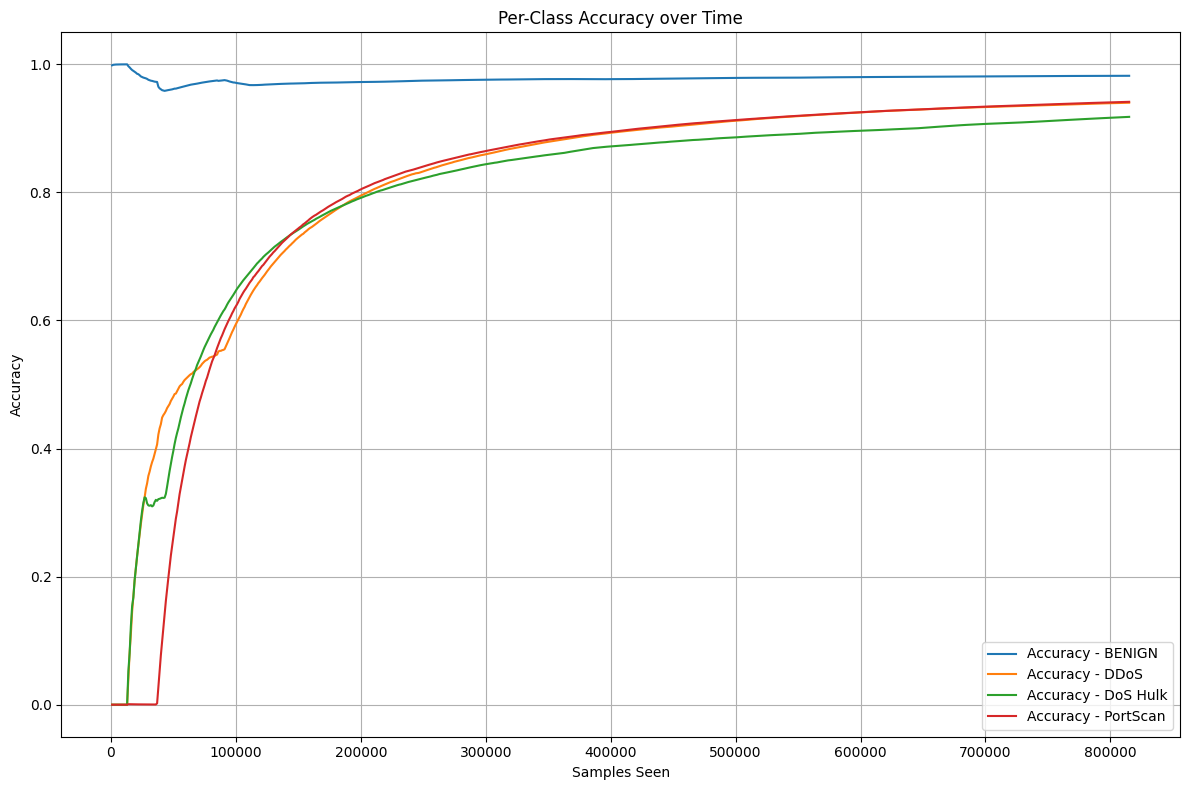

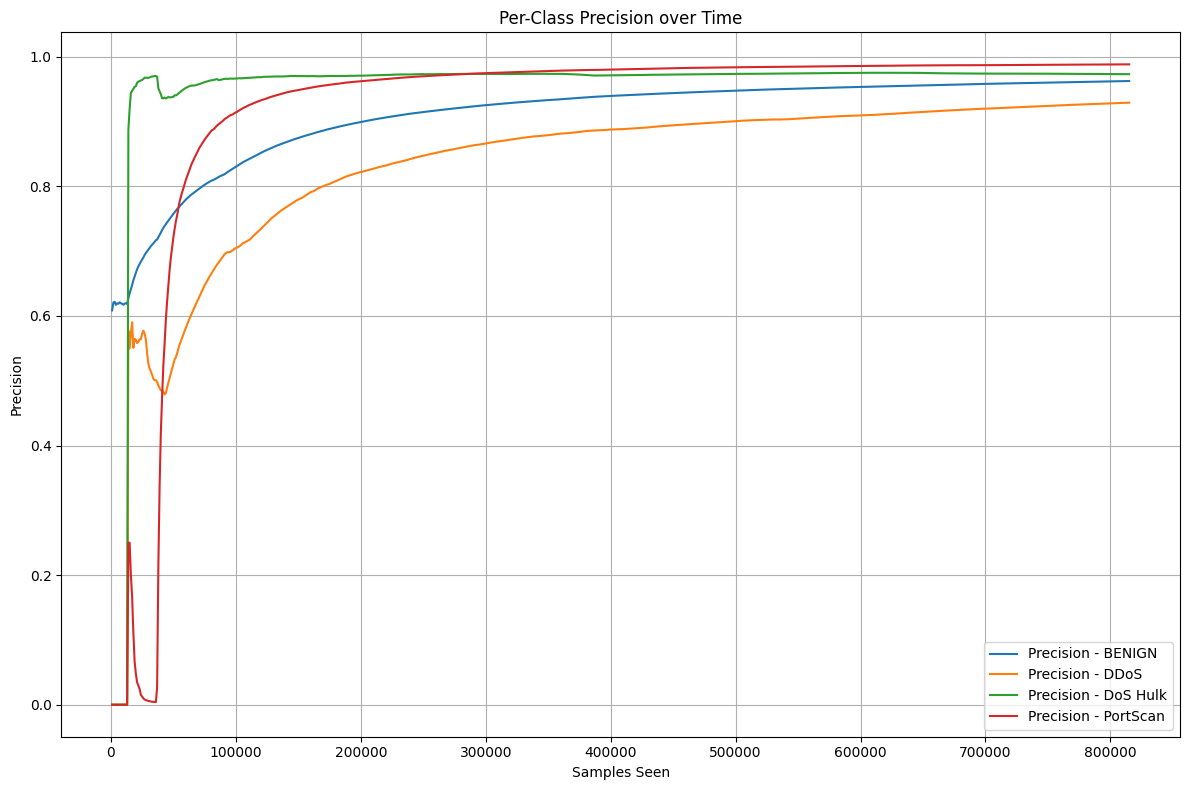

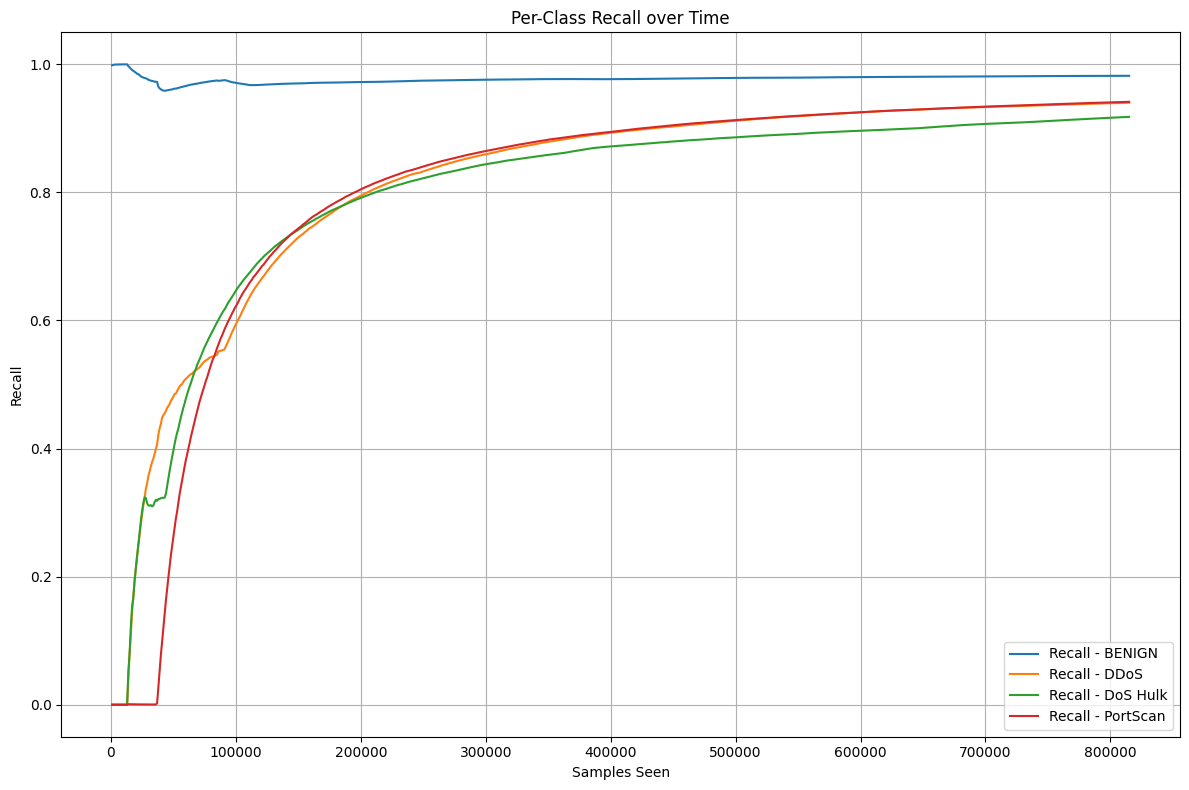

In [7]:
# Plot three metrics of training phase
plot_class_metric_over_time(class_metrics, steps, label_mapping, 'accuracy')
plot_class_metric_over_time(class_metrics, steps, label_mapping, 'precision')
plot_class_metric_over_time(class_metrics, steps, label_mapping, 'recall')

In [8]:
# Save the model for later usage
with open('models/model.pkl', 'wb') as f:
    pickle.dump(model, f)